In [1]:
# dependencies; uncomment if not yet installed

# !pip install iexfinance
# !pip install numerapi

In [2]:
import os
import time

import numerapi
import numpy as np
import pandas as pd
from iexfinance import stocks
from iexfinance.utils.exceptions import IEXQueryError
from tqdm.auto import tqdm

## IEX

IEX (Investor's Exchange) is quite a new stock exchange, founded in 2012 with the mission to build fairer markets. At this time it is one of the few (if not the only) exchange that offers a free API key to their data. You can sign up for one through this referral link (select the "Start plan"): https://iexcloud.io/s/696fc940.

Each API call has a certain 'weight' associated with it, and this weight is deducted from your monthly credit balance. **Fortunately for testing purposes there is a sandbox mode**, which doesn't cost any credits but does sometimes produce garbled values.

The docs are quite thorough (https://iexcloud.io/docs/api/), but to make things easier I used the third party Python SDK [iexfinance](https://github.com/addisonlynch/iexfinance).

(note: I later also found out there is a native Python interface called [pyEX](https://github.com/iexcloud/pyEX))

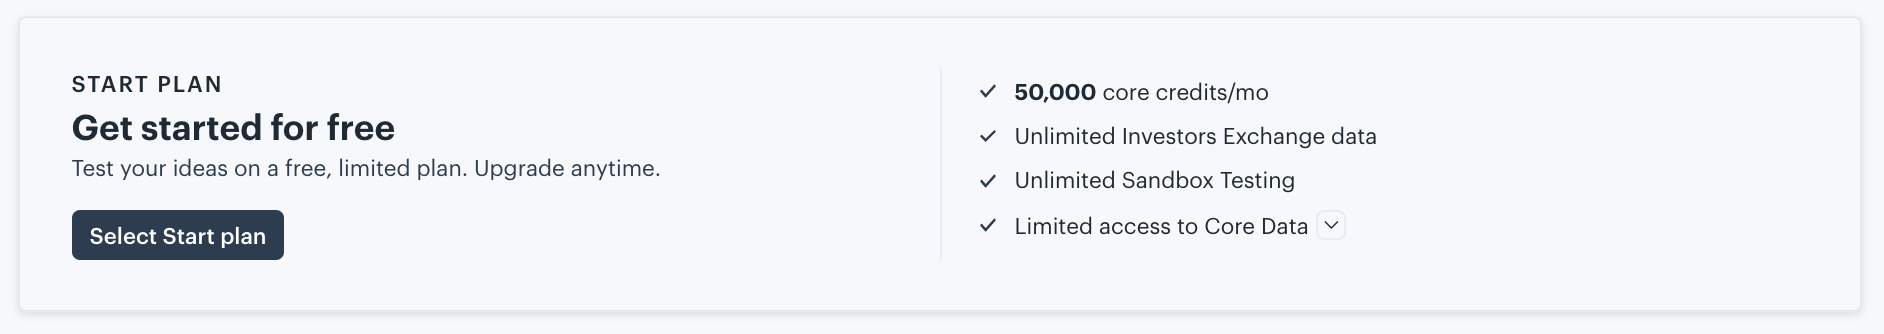

Replace the `XXXXXXXXX`s below with your own `SECRET` API tokens from IEX Cloud: https://iexcloud.io/console/tokens. There's a toggle in the console's left menu to switch between real and sandbox mode. Make sure to switch that on when retrieving your token!

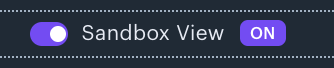

Numerai's API keys can be found here: https://numer.ai/account

In [3]:
SANDBOX = True

os.environ['IEX_TOKEN'] = 'XXXXXXXXX' if SANDBOX else 'XXXXXXXXX'
os.environ['IEX_API_VERSION'] = 'iexcloud-sandbox' if SANDBOX else 'stable'
os.environ['NUMERAI_PUBLIC_ID'] = 'XXXXXXXXX'
os.environ['NUMERAI_SECRET_KEY'] = 'XXXXXXXXX'

# replace with your own Numerai Signals model name
MODEL_NAME = 'gosuto_test'

Let's start with retrieving Numerai's ticker universe:

In [4]:
napi = numerapi.SignalsAPI()

universe = pd.DataFrame({'bloomberg_ticker': napi.ticker_universe()})
universe[['ticker', 'region']] = universe['bloomberg_ticker'].str.split(' ', n=2, expand=True)

The data we will request in this notebook (dividends) is only available for the US region in the free API tier. Limit the universe as such:

In [5]:
universe = universe[universe['region'] == 'US']
universe

,bloomberg_ticker,ticker,region
283,MLCO US,MLCO,US
285,HCM US,HCM,US
327,SE US,SE,US
898,SIMO US,SIMO,US
907,HIMX US,HIMX,US
...,...,...,...
5425,ACA US,ACA,US
5426,IMUX US,IMUX,US
5427,IMAX US,IMAX,US
5428,VERO US,VERO,US


## Dividend Yield
The idea for the signal we are going to create here is quite simple: calculate the dividend APY (annual percentage yield). How much dividend is returned on a yearly basis for every dollar invested in a stock?

For this we'll need it's daily price, the amount of dividend payed out and its frequency.

https://www.investopedia.com/terms/d/dividendyield.asp

In [6]:
def get_stock_dividends(symbol, range):
    try:
        dividends = stocks.Stock(symbol).get_dividends(range=range)
    except ConnectionError as e:
        print(e)
        print('retrying after 30 seconds...')
        time.sleep(31)
        get_stock_dividends(symbol, range)
    return dividends

In [7]:
data = []
not_found = []
for _, symbol, bloomberg_ticker in tqdm(list(universe[['ticker', 'bloomberg_ticker']].itertuples())):
    try:
        # use a range of up to 1y for extended backtesting of the validation set
        dividends = get_stock_dividends(symbol, range='1y')
        if not dividends.empty:
            dividends.index = pd.to_datetime(dividends.index)
            # NOTE: Stocks that used to payout dividends but do not anymore are not filtered out
            # how often per year are dividends payed out?
            dividends['frequency_int'] = dividends['frequency'].str.strip().map({
                'annual': 1,
                'semi-annual': 2,
                'quarterly': 4,
                'monthly': 12,
                'weekly': 52,
                'daily': 365,
            })
            prices = stocks.get_historical_data(symbols=symbol, start=dividends.index.min(), close_only=True)
            # resample both prices and dividends to daily time series
            # last known price/dividends is always assumed best truth, hence ffill
            joined = prices.resample('D').ffill().join(dividends.resample('D').ffill()).ffill()
            # calculate the dividend apy of the stock
            joined['div_apy'] = joined['amount'] * joined['frequency_int'] / joined['close']

            joined['bloomberg_ticker'] = bloomberg_ticker
            data.append(joined[['bloomberg_ticker', 'div_apy']])
    except IEXQueryError:
        not_found.append(symbol)
full_data = pd.concat(data).sort_index()

if len(not_found) > 0:
    print(f'could not retrieve the following symbols: {not_found}')

print(f"retrieved usable dividend data for {full_data['bloomberg_ticker'].nunique()} symbols.")

  0%|          | 0/2255 [00:00<?, ?it/s]

could not retrieve the following symbols: ['BRK/B', 'BF/B', 'BF/A', 'LEN/B', 'MOG/A', 'CWEN/A', 'LGF/A', 'LGF/B']
retrieved usable dividend data for 1119 symbols.


Now we divide the calculated APY across daily quintiles. For any given day, we thus end up with a ranking of all the stocks' dividend APY:

In [8]:
full_data['signal'] = (full_data
    .groupby(full_data.index)['div_apy']
    .transform(lambda date: pd.qcut(date, 5, labels=False, duplicates='drop')) / 4
)

In order to work with weekly data on Fridays I use `.asfreq('W-FRI')` here; dropping all other days. This means the signal is based on the price and APY known on that Friday of the week. A better approach might be to take the weekly averages or maxima---I haven't experimented with this yet.

In [9]:
# read in numerai signals' targets
try:
    targets = pd.read_csv('numerai_signals_historical.csv')
except FileNotFoundError:
    napi.download_validation_data()
    targets = pd.read_csv('numerai_signals_historical.csv')
targets['friday_date'] = pd.to_datetime(targets['friday_date'], format='%Y%m%d')
targets = targets.rename({'friday_date': 'date'}, axis=1).set_index('date')

# covert to time series consisting of only Fridays
data_for_merge = (full_data
    .groupby('bloomberg_ticker')
    .apply(lambda x: x.asfreq('W-FRI'))
    .droplevel(0)
    .sort_index()
    .reset_index()
    .rename({'index': 'date'}, axis=1)
    .drop('div_apy', axis=1)
    .dropna()
)

In [10]:
# merge with targets
print("merging with numerai's targets...")
preds = pd.merge(data_for_merge, targets, how='left', on=['date', 'bloomberg_ticker']).set_index('date')
# define live targets (last known Friday)
preds.loc[preds.index[-1], 'data_type'] = 'live'
# drop everything else that could not be merged
preds = preds[~preds['data_type'].isna()]
print(f"successfully merged {preds['bloomberg_ticker'].unique().size} symbols")

merging with numerai's targets...
successfully merged 1100 symbols


In [11]:
# a quick look at the mean correlation of the signal with the validation target
preds[preds['data_type'] == 'validation'][['signal', 'target']].corr()['target'][0]

0.004361310883621178

In [12]:
# build submission, write to file and upload

submission = (preds
    .reset_index()
    .rename({'date': 'friday_date'}, axis=1)
    [['bloomberg_ticker', 'friday_date', 'data_type', 'signal']]
).to_csv('submission.csv', index=False)
napi.upload_predictions('submission.csv', model_id=napi.get_models()[MODEL_NAME])

2021-04-11 15:16:05,506 INFO numerapi.base_api: uploading predictions...


'2deea585-bc4d-4f6d-a3c6-24bb973cff74'

Overall the signal is still quite rough:
- free API limits region and historical time horizon
- weekly data could be aggregated better
- are daily quintiles the best way to go here?
- would a machine learning model be able to find a better transformation of the signal?

The diagnostics for this signal do show some potential, especially from 2020 onwards. Maybe due to stock prices falling last year but some dividends remaining constant...?

Live performance can be tracked here: https://signals.numer.ai/gosuto_test

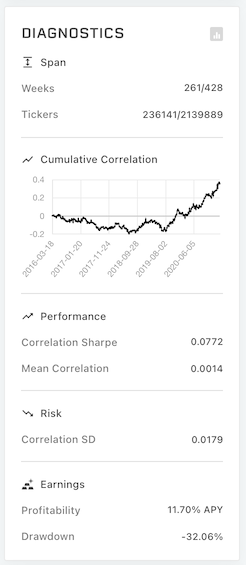